In [1]:
! pip install -q torchcfm torchdyn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.4.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cudf 23.8.0 requir

In [2]:
import os
import shutil
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchcfm.models.unet import UNetModel
from torchcfm import SchrodingerBridgeConditionalFlowMatcher
from torchdyn.core import NeuralODE
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from sklearn.model_selection import train_test_split

2024-05-03 14:57:48.168772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 14:57:48.168879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 14:57:48.301792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Extracting zip files
from zipfile import ZipFile

dataset = '/kaggle/input/dogs-vs-cats/train.zip'
test_dataset = '/kaggle/input/dogs-vs-cats/test1.zip'

with ZipFile(dataset, 'r') as zipf:
    zipf.extractall()
with ZipFile(test_dataset, 'r') as zipf:
    zipf.extractall()

In [4]:
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test1'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]
cat_train_dir = '/kaggle/working/train/cat'
dog_train_dir = '/kaggle/working/train/dog'

os.makedirs(cat_train_dir, exist_ok=True)
os.makedirs(dog_train_dir, exist_ok=True)

In [5]:
for file in cat_files:
    shutil.move(os.path.join(train_dir, file), cat_train_dir)
    
for file in dog_files:
    shutil.move(os.path.join(train_dir, file), dog_train_dir)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, file_paths: str):
        self.file_paths = file_paths
        self.transforms = T.Compose([
            T.CenterCrop(size=(256, 256)),
            T.Resize(size=(128, 128)),
            T.ToTensor(),
            T.Normalize(mean=0.5, std=0.5),
        ])
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx])
        return self.transforms(img)

In [7]:
dog_paths = glob.glob("train/dog/*.jpg")
train_dog_paths, test_dog_paths = train_test_split(dog_paths, test_size=2500, shuffle=True)

cat_paths = glob.glob("train/cat/*.jpg")
train_cat_paths, test_cat_paths = train_test_split(cat_paths, test_size=2500, shuffle=True)

In [8]:
dog_trainset = ImageDataset(train_dog_paths)
cat_trainset = ImageDataset(train_cat_paths)

dog_testset = ImageDataset(test_dog_paths)
cat_testset = ImageDataset(test_cat_paths)

In [9]:
dog_train_loader = DataLoader(dog_trainset, batch_size=32, shuffle=True)
cat_train_loader = DataLoader(cat_trainset, batch_size=32, shuffle=True)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(dim=(3, 128, 128), num_channels=32, num_res_blocks=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = SchrodingerBridgeConditionalFlowMatcher()

In [11]:
num_epochs = 5
num_steps = num_epochs * len(dog_train_loader)

pbar = tqdm(total=num_steps)
losses = []

for epoch in range(num_epochs):
    for (x0, x1) in zip(cat_train_loader, dog_train_loader):
        x0 = x0.to(device)
        x1 = x1.to(device)
        
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        
        loss = F.mse_loss(vt, ut)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})
        pbar.update()
        
pbar.close()

  0%|          | 0/1565 [00:00<?, ?it/s]

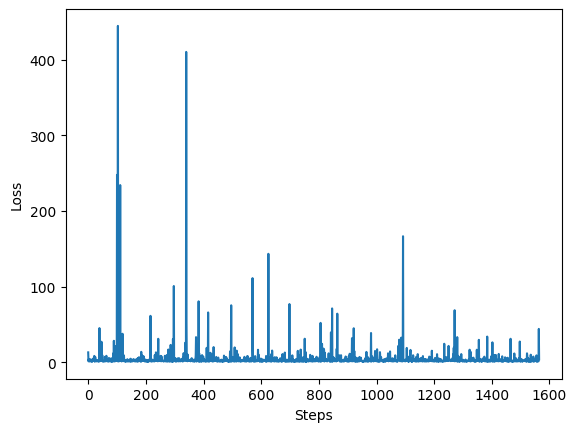

In [12]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [13]:
solver = NeuralODE(model, sensitivity='adjoint', solver='dopri5').to(device)

## Cat-to-Dog

In [14]:
num_samples = 16
nfe = 100
t_span = torch.linspace(0, 1, nfe)

test_loader = DataLoader(cat_testset, batch_size=num_samples, shuffle=True)
x0 = next(iter(test_loader)).to(device)

with torch.no_grad():
    t_eval, trajectory = solver(x0, t_span)
    
x1 = trajectory[-1]
x1 = torch.clamp(x1, min=-1., max=1.)

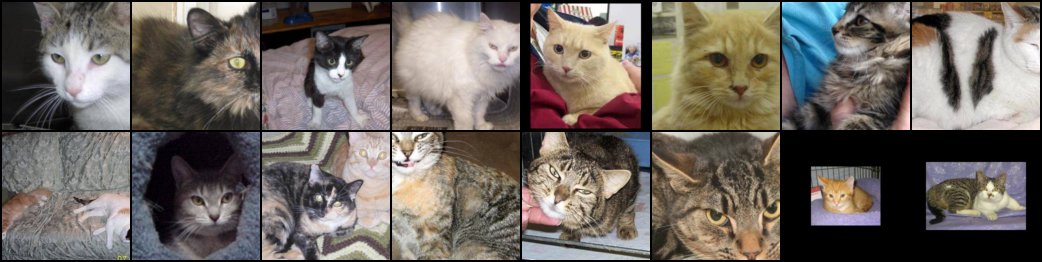

In [15]:
# Source Distribution
ToPILImage()(make_grid((x0 + 1) * 0.5, nrow=8))

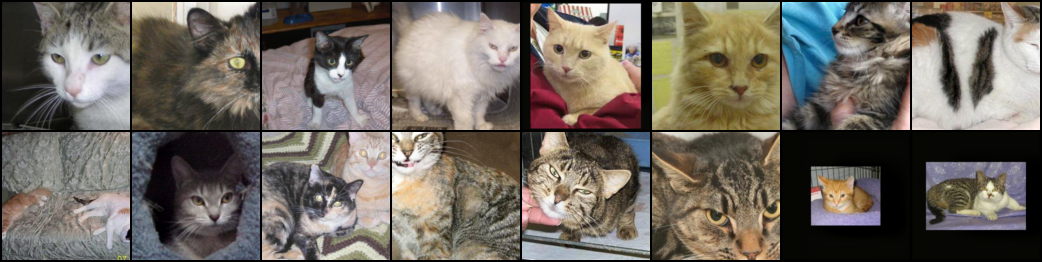

In [16]:
# Target Distribution
ToPILImage()(make_grid((x1 + 1) * 0.5, nrow=8))

## Dog-to-Cat

In [17]:
num_samples = 16
nfe = 10
t_span = torch.linspace(1, 0, nfe)

test_loader = DataLoader(dog_testset, batch_size=num_samples, shuffle=True)
x1 = next(iter(test_loader)).to(device)

with torch.no_grad():
    t_eval, trajectory = solver(x1, t_span)
    
x0 = trajectory[-1]
x0 = torch.clamp(x0, min=-1., max=1.)

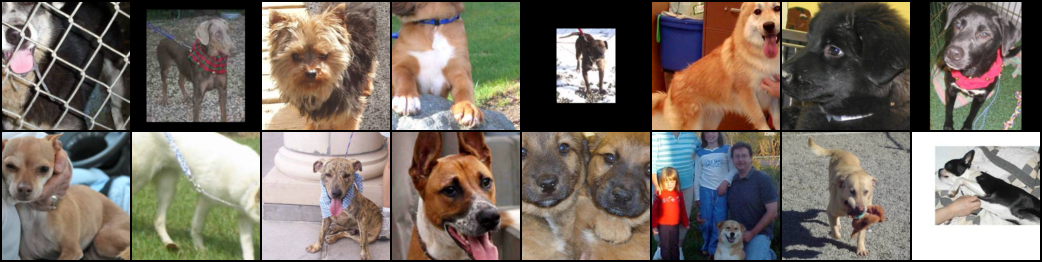

In [18]:
# Source Distribution
ToPILImage()(make_grid((x1 + 1) * 0.5, nrow=8))

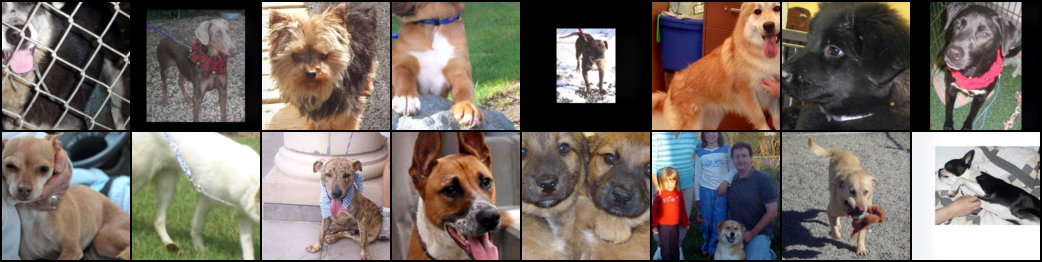

In [19]:
# Target Distribution
ToPILImage()(make_grid((x0 + 1) * 0.5, nrow=8))